# 2025-11-07 Quadrature

* Polynomial interpolation for integration

* Gauss quadrature

In [1]:
using LinearAlgebra
using Plots
using Polynomials
default(lw=4, ms=5, legendfontsize=12, xtickfontsize=12, ytickfontsize=12)

# Vandermonde with Legendre polynomials
function vander_legendre(x, n=nothing)
    if isnothing(n)
        n = length(x) # Square by default
    end
    m = length(x)
    Q = ones(m, n)
    if n > 1
        Q[:, 2] = x
    end
    for k in 1:n-2
        Q[:, k+2] = ((2*k + 1) * x .* Q[:, k+1] - k * Q[:, k]) / (k + 1)
    end
    Q
end

# And a utility for points distributed via cos
CosRange(a, b, n) = (a + b)/2 .+ (b - a)/2 * cos.(LinRange(-pi, 0, n))

# Some test functions
F_expx(x) = exp(2x) / (1 + x^2)
f_expx(x) = 2*exp(2x) / (1 + x^2) - 2x*exp(2x)/(1 + x^2)^2

F_dtanh(x) = tanh(x)
f_dtanh(x) = cosh(x)^-2

integrands = [f_expx, f_dtanh]
antiderivatives = [F_expx, F_dtanh]
tests = zip(integrands, antiderivatives)

# Plotting utils for accuracy
function plot_accuracy(fint, tests, ns; ref=[1,2])
    a, b = -2, 2
    p = plot(xscale=:log10, yscale=:log10, xlabel="n", ylabel="error")
    for (f, F) in tests
        Is = [fint(f, a, b, n=n) for n in ns]
        Errors = abs.(Is .- (F(b) - F(a)))
        scatter!(ns, Errors, label=f)
    end
    for k in ref
        plot!(ns, ns.^(-1. * k), label="\$n^{-$k}\$")
    end
    p
end

function plot_accuracy_h(fint, tests, ns; ref=[1,2])
    a, b = -2, 2
    p = plot(xscale=:log10, yscale=:log10, xlabel="h", ylabel="error",
        legend=:bottomright)
    hs = (b - a) ./ ns
    for (f, F) in tests
        Is = [fint(f, a, b, n=n) for n in ns]
        Errors = abs.(Is .- (F(b) - F(a)))
        scatter!(hs, Errors, label=f)
    end
    for k in ref
        plot!(hs, hs.^k, label="\$h^{$k}\$")
    end
    p
end

# And the Trap rule
function fint_trapezoid(f, a, b; n=20)
    dx = (b - a) / (n - 1)
    x = LinRange(a, b, n)
    fx = f.(x)
    fx[1] /= 2
    fx[end] /= 2
    sum(fx) * dx
end

fint_trapezoid (generic function with 1 method)

## Integration

We're interested in computing definite integrals

$$ \int_a^b f \left( x \right) \, dx $$

and will usually consider finite domains $-\infty < a < b < \infty$.

We need to consider

* Cost: (usually) how many times we need to evaluate $f \left( x \right)$

* Accuracy:

    * compare to a reference value
 
    * compare to the same method using more evaluations

We also need to consider how smooth $f \left( x \right)$ is.

Last time we integrated a piecewise linear fit, known as using the Trapezoid Rule.

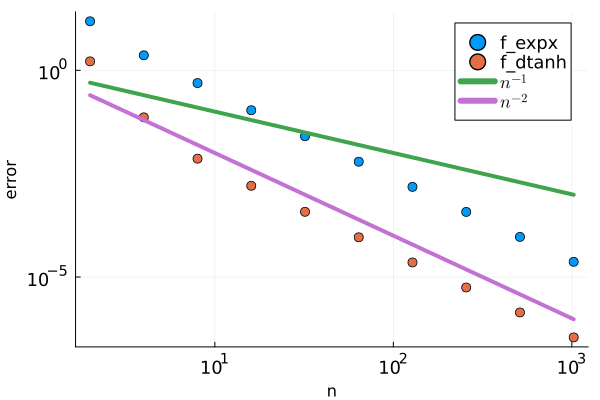

In [2]:
# Compute the integral using piecewise linear polynomial fit
function fint_trapezoid(f, a, b; n=20)
    dx = (b - a) / (n - 1)
    x = LinRange(a, b, n)
    fx = f.(x)
    fx[1] /= 2
    fx[end] /= 2
    sum(fx) * dx
end

plot_accuracy(fint_trapezoid, tests, 2 .^ (1:10))

## Extrapolation

Let's switch our plot to use $h = \Delta x$ instead of the number of points $x$.

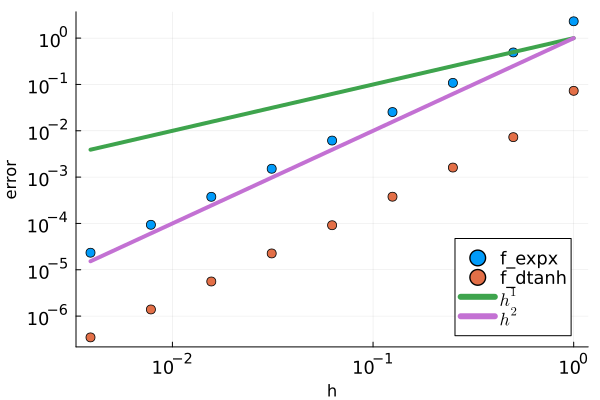

In [3]:
plot_accuracy_h(fint_trapezoid, tests, 2 .^ (2:10))

The trapezoid rule with $n$ points has an interval spacing of $h = 1 / \left( n - 1 \right)$.
Let $I_h$ be the value of the integral approximated using an interval $h$.
We have numerical evidence that the leading error term is $\mathcal{O} \left( h^2 \right)$, which is to say

$$ I_h - I_0 = c h^2 + \mathcal{O} \left( h^3 \right) $$

for some as-yet unknown constant $c$ that will depend upon the function being integrated and the domain of integration. If we can determine $c$ from two approximations, say $I_h$ and $I_{2h}$, then we can extrapolate to $h = 0$.

For sufficiently small $h$, we can neglect $\mathcal{O} \left( h^3 \right)$ and write

$$ \begin{align}
  I_h    - I_0 &= c h^2\\
  I_{2h} - I_0 &= c \left( 2 h \right)^2 
\end{align} $$

Subtracting these two lines, we have

$$ I_h - I_{2h} = c \left( h^2 - 4 h^2 \right) $$

which can be solved for $c$ as

$$ c = \frac{I_h - I_{2h}}{h^2 - 4 h^2} $$

Substituting back into the first equation, we solve for $I_0$ as

$$ I_0 = I_h - c h^2 = I_h + \frac{I_h - I_{2h}}{4 - 1} $$

This is called [**Richardson extrapolation**](https://en.wikipedia.org/wiki/Richardson_extrapolation).

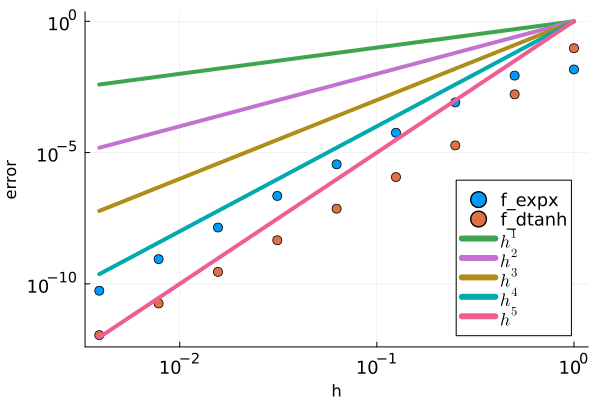

In [4]:
function fint_richardson(f, a, b; n=20)
    n = div(n, 2) * 2 + 1
    h = (b - a) / (n - 1)
    x = LinRange(a, b, n)
    # Evaluate our function once
    fx = f.(x)
    fx[[1, end]] /= 2
    # Itegrate with h and 2h
    I_h = sum(fx) * h
    I_2h = sum(fx[1:2:end]) * 2h
    # Estimate I_0 per our math above
    I_h + (I_h - I_2h) / 3
end

# And how does it do?
plot_accuracy_h(fint_richardson, tests, 2 .^ (2:10), ref=1:5)

We now have a sequence of accurate approximations.
It is possible to apply this extrapolation recursively, and it works great if we have a number of points that is a power of $2$ and our function is "nice enough".

## Quadrature form

At the end of the bay, we're taking a weighted sum of function values.
We call $w_i$ the *quadrature weights* and $x_i$ the *quadrature points* or *abscissa*.

$$ \int_a^b f \left( x \right) \approx \sum_{i = 1}^n w_i f \left( x_i \right) = \mathbf{w}^T f \left( \mathbf{x} \right) $$

In [5]:
# Compute the weights and values for the trap rule
function quad_trapezoid(a, b; n=20)
    dx = (b - a) / (n - 1)
    x = LinRange(a, b, n)
    w = fill(dx, n)
    w[[1, end]] /= 2
    x, w
end

quad_trapezoid (generic function with 1 method)

In [6]:
x, w = quad_trapezoid(-1, 1)

w' * cos.(x) - fint_trapezoid(cos, -1, 1)

2.220446049250313e-16

## Polynomial interpolation for integration

Now let's use our work on polynomial interpolation to see if we can develop a different approach to quadrature (numerical integration).

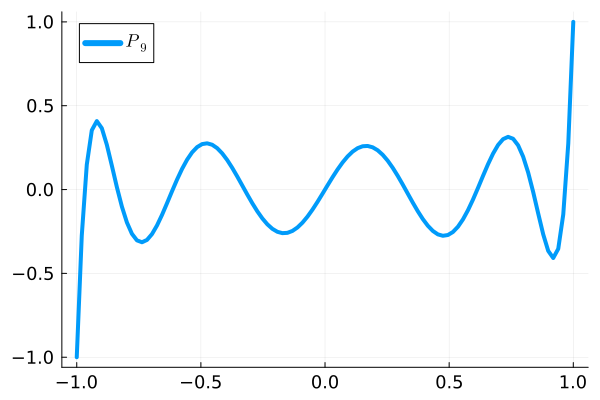

In [7]:
x = LinRange(-1, 1, 100)
P = vander_legendre(x, 10)
plot(x, P[:,end], label="\$P_9\$")

We want to sample our function $f \left( x \right)$ at some points $x \in \left[ -1, 1 \right]$, fit a polynomial through these points, and return the integral of that interpolating polynomial.

* What points do we sample on?

* How do we integrate the interpolating polynomial?

Recall that the Legendre polynomials $P_0 \left( x \right) = 1$, $P_1 \left( x \right) = x$, $\dots$, are pairwise orthogonal

$$ \int_{-1}^1 P_m \left( x \right) P_n \left( x \right) = 0, \forall m \neq n $$

### Let's see the code

In [8]:
# Weights and points for quadrature
function quad_legendre(a, b; n=20)
    x = CosRange(-1, 1, n)
    P = vander_legendre(x)
    x_ab = (a+b)/2 .+ (b-a)/2*x
    w = (b - a) * inv(P)[1,:]
    x_ab, w
end

# Function to actually do the integration
function fint_legendre(f, a, b; n=20)
    x, w = quad_legendre(a, b, n=n)
    w' * f.(x)
end

# Test
fint_legendre(x -> 1 + x, -1, 1, n=4)

2.0

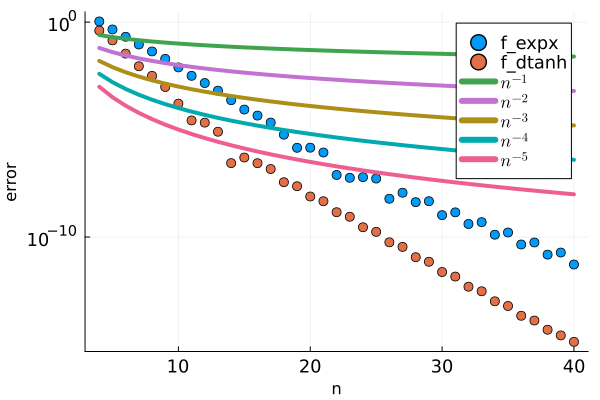

In [9]:
p = plot_accuracy(fint_legendre, tests, 4:40, ref=1:5)
plot!(p, xscale=:linear)

## We can do better

Suppose a polynomial on the interval $\left[ -1, 1 \right]$ can be written as

$$ P_n \left( x \right) q \left( x \right) + r \left( x \right) $$

where $P_n \left( x \right)$ is the $n$th Legendre polynomials and both $q \left( x \right)$ and $r \left( x \right)$ are polynomials of degree at most $n - 1$.

* Why is $\int_{-1}^1 P_n \left( x \right) q \left( x \right) = 0$?

* Can every polynomial of degree $2 n - 1$ be written in the above form?

* How many roots does $P_n \left( x \right)$ have on the interval?

* Can we choose points $\lbrace x_i \rbrace$such that the first term is 0?

If $P_n \left( x_i \right) = 0$ for each $x_i$, then we need only integrate $r \left( x \right)$, which is done exactly by interpolating polynomial.
How do we find these roots $x_i$?

## Gauss-Legendre in code

1. Solve for the points, compute the weights

    * Use a Newton solver to find the roots. You can use the recurrence to write a recurrence for the derivatives.

    * Create a Vandermonde matrix and extract the first row of the inverse or (using more structure) the derivatives at the quadrature points.

2. Use duality of polynomial roots and matrix eigenvalues.

    * A fascinating mathematical voyage; something you might see more in a graduate linear algebra class.

In [10]:
function fint_gauss(f, a, b; n=4)
    """Gauss-Legendre integration using Golub-Welsch algorithm"""
    beta = @. .5 / sqrt(1 - (2 * (1:n-1))^(-2))
    T = diagm(-1 => beta, 1 => beta)
    D, V = eigen(T)
    w = V[1,:].^2 * (b-a)
    x = (a+b)/2 .+ (b-a)/2 * D
    w' * f.(x)
end
fint_gauss(sin, -2, 3, n=4)

0.5733948071694299

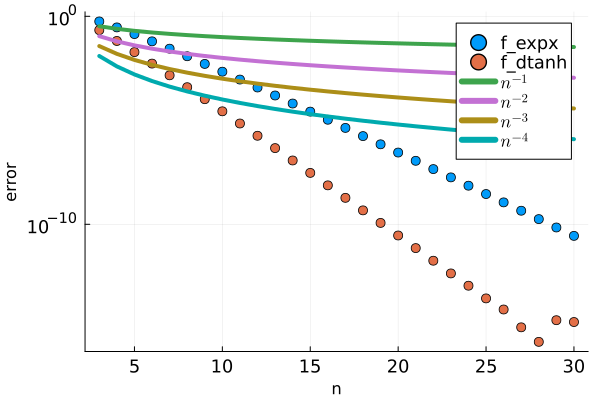

In [11]:
plot_accuracy(fint_gauss, tests, 3:30, ref=1:4)
plot!(xscale=:linear)

The $n$-point Gauss quadrature exactly integrates polynomials of degree $2 n - 1$.

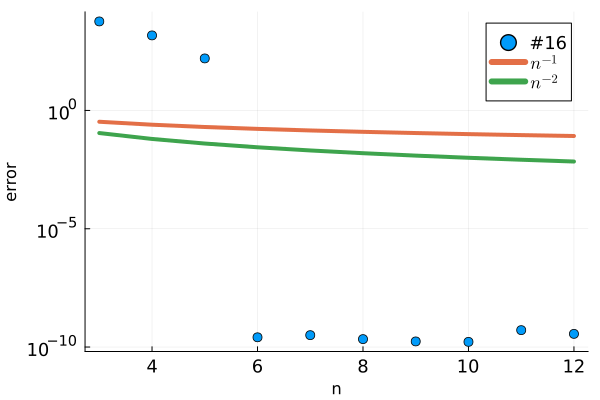

In [12]:
plot_accuracy(fint_gauss, [(x -> 12(x-.2)^11, x->(x-.2)^12)], 3:12)
plot!(xscale=:linear)

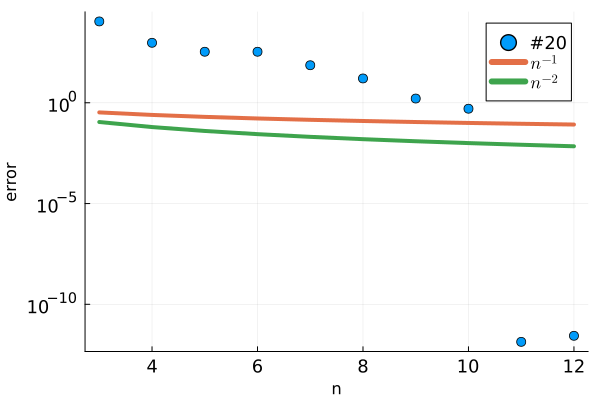

In [13]:
plot_accuracy(fint_legendre, [(x -> 11x^10, x->x^11)], 3:12)
plot!(xscale=:linear)

## [FastGaussQuadrature.jl](https://juliaapproximation.github.io/FastGaussQuadrature.jl/stable/)

There are packages to help us here.

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


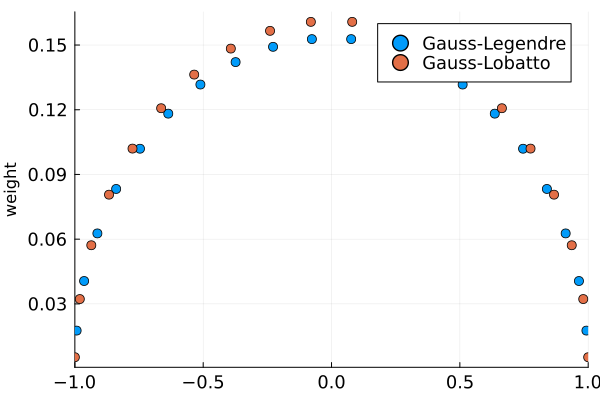

In [14]:
using Pkg
pkg"add FastGaussQuadrature"
using FastGaussQuadrature

n = 20
x, q = gausslegendre(n)
scatter(x, q, label="Gauss-Legendre", ylabel="weight", xlims=(-1, 1))
scatter!(gausslobatto(n)..., label="Gauss-Lobatto")